<a href="https://colab.research.google.com/github/Ibrah-N/Deep-Learning-Projects-Computer-Vision/blob/main/dl_13_human_emotion_detection_finetuning_transfer_learning_resnet34_efficientNetB4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installs & Imports

In [ ]:
!pip install -q kaggle

In [6]:
# prompt: mount the drive

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf

## Data Loading & Preprocessing

In [ ]:
# setup the api

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# dowload dataset

!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
 96% 297M/309M [00:02<00:00, 147MB/s]
100% 309M/309M [00:02<00:00, 119MB/s]


In [ ]:
# copy dataset to mydrive

!cp human-emotions-datasethes.zip gdrive/MyDrive/

cp: cannot stat 'human-emotions-datasethes.zip': No such file or directory


In [7]:
# Extract Downloaded Dataset
# !unzip -q human-emotions-datasethes.zip -d dataset/


# Extract Saved dataset
!unzip -q gdrive/MyDrive/human-emotions-datasethes.zip -d dataset/

In [32]:
# Configurations

TRAIN_DIR = '/content/dataset/Emotions Dataset/Emotions Dataset/train/'
VAL_DIR = '/content/dataset/Emotions Dataset/Emotions Dataset/test/'


CONFIG = {
    'IM_SIZE' : 256,
    'BATCH_SIZE' : 32,
    'N_CLASSES': 3,
    'LABELS' : ['angry', 'happy', 'sad'],
    'EPOCHS' : 7,
    'SEED' : 42,
    'FILTER_SIZE': 16,
    'POOL_SIZE': 2,
    'KERNEL_SIZE': 3,
    'DROPOUT_RATE': 0.0,
    'LEARNING_RATE': 0.001,
    'DENSE_1': 32,
    'DENSE_2': 16,
    }


In [9]:
# create tensorflow dataset

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIG['LABELS'],
    batch_size=None,
    image_size=(CONFIG['IM_SIZE'], CONFIG['IM_SIZE']),
    seed=CONFIG['SEED'],
)


validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIG['LABELS'],
    batch_size=None,
    image_size=(CONFIG['IM_SIZE'], CONFIG['IM_SIZE']),
    seed=CONFIG['SEED'],
)

Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.


In [10]:
# rescalling data

def resize_rescale(image, label):
    image  = tf.image.resize(image, (CONFIG['IM_SIZE'], CONFIG['IM_SIZE']))
    image = tf.cast(image/255. , tf.float32)
    return image, label

In [11]:
# train dataset prefetch

train_dataset = (
    train_dataset
    .map(resize_rescale)
    .batch(CONFIG['BATCH_SIZE'])
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [12]:
# validation dataset prefetch

validation_dataset = (
    validation_dataset
    .map(resize_rescale)
    .batch(CONFIG['BATCH_SIZE'])
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [13]:
print(train_dataset.element_spec)
print(validation_dataset.element_spec)


(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))


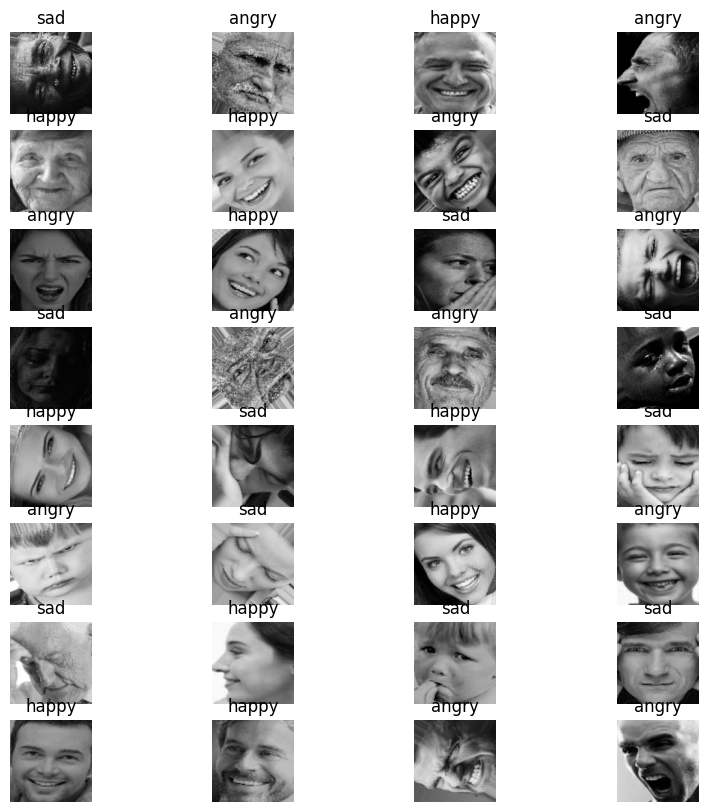

In [14]:
# visulize batch data

def visulaize_batch(dataset, rows, cols):
  """
    dataset : batch dataset shape (batch, im_size, im_size, 3)
    rows : number of rows(int)
    cols : number of cols(int)
  """

  row = 0
  col = 0
  _, axs = plt.subplots(rows, cols, figsize=(10, 10))

  for x, y in train_dataset.take(1):
    for img, lbl in zip(x, y):
      if row == rows and col < cols:
        col += 1
        row = 0
      axs[row, col].imshow(img)
      axs[row, col].set_title(CONFIG['LABELS'][np.argmax(lbl)])
      axs[row, col].axis('off')
      row += 1


visulaize_batch(train_dataset.take(1), 8, 4)

### Wandb

In [ ]:
# wandb installation

!pip install -q wandb
import wandb

In [ ]:
from wandb.keras import WandbCallback
wandb.login(key="791da7778092369c33534951b74dedb4e5749326")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Initialize the run

wandb.init(project="Human-Emotion", entity="Ibrah", config=CONFIG)

## Model Arch & Training

### Random Architecture

In [ ]:
# model architecture

emotion_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(CONFIG['IM_SIZE'], CONFIG['IM_SIZE'], 3)),


    tf.keras.layers.Conv2D(filters=CONFIG['FILTER_SIZE'], kernel_size=CONFIG['KERNEL_SIZE'],
                           activation='relu'),
    tf.keras.layers.Dropout(rate=CONFIG['DROPOUT_RATE']),
    tf.keras.layers.BatchNormalization(),


    tf.keras.layers.Conv2D(filters=CONFIG['FILTER_SIZE']*2, kernel_size=CONFIG['KERNEL_SIZE'],
                           activation='relu'),
    tf.keras.layers.BatchNormalization(),


    tf.keras.layers.Conv2D(filters=CONFIG['FILTER_SIZE']*3, kernel_size=CONFIG['KERNEL_SIZE'],
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=CONFIG['POOL_SIZE']),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=CONFIG['DENSE_1'], activation='relu'),
    tf.keras.layers.Dropout(rate=CONFIG['DROPOUT_RATE']),
    tf.keras.layers.BatchNormalization(),


    tf.keras.layers.Dense(units=CONFIG['DENSE_2'], activation='relu'),
    tf.keras.layers.Dense(units=CONFIG['N_CLASSES'], activation='softmax')
])

### EfficientNet B4

In [17]:
# model backbone

eff_b4_backbone = tf.keras.applications.EfficientNetB4(
    include_top=False,
    weights='imagenet',
    classes=CONFIG['N_CLASSES'],
    classifier_activation='softmax'
)

71686520/71686520 [==============================] - 1s 0us/step


In [28]:
eff_b4_backbone.trainable = True

In [31]:
# eff_b4_emotion_model

input = tf.keras.layers.Input(shape=(CONFIG['IM_SIZE'], CONFIG['IM_SIZE'], 3))
x = eff_b4_backbone(input, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(units=CONFIG['DENSE_1'], activation='relu')(x)
x = tf.keras.layers.Dense(units=CONFIG['DENSE_2'], activation='relu')(x)
x = tf.keras.layers.Dense(units=CONFIG['N_CLASSES'], activation='softmax')(x)

eff_b4_emotion_model = tf.keras.Model(input, x)

### Custom Resnet 34

In [8]:
class CustomConv2D(tf.keras.layers.Layer):
  def __init__(self, filters, kernel_size, strides=1, padding='valid'):
    super(CustomConv2D, self).__init__(name="Custom_Conv2D")

    self.conv1 = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu')
    self.batch1 = tf.keras.layers.BatchNormalization()

  def call(self, x, training=True):
    x = self.conv1(x)
    x = self.batch1(x)

    return x


In [14]:
class ResedualBlock(tf.keras.layers.Layer):
  def __init__(self, filters, strides=1):
    super(ResedualBlock, self).__init__(name="Resedual_Block")

    self.dotted = (strides != 1)

    self.conv1 = CustomConv2D(filters=filters, kernel_size=(3, 3), strides=strides, padding='same')
    self.conv2 = CustomConv2D(filters=filters, kernel_size=(3, 3), strides=1, padding='same')

    self.activation_1 = tf.keras.layers.Activation('relu')

    if self.dotted:
      self.conv3 = CustomConv2D(filters=filters, kernel_size=(1, 1), strides=strides, padding='same')


  def call(self, input, training=True):
    x = self.conv1(input)
    x = self.conv2(x)

    if self.dotted:
      x_add = self.conv3(input)
      x_add = tf.keras.layers.Add()([x_add, x])
    else:
      x_add = tf.keras.layers.Add()([x, input])

    return self.activation_1(x_add)

In [18]:
class ResNet34(tf.keras.models.Model):
  def __init__(self, num_classes):
    super(ResNet34, self).__init__(name="Resnet_34_Model")

    self.conv1 = CustomConv2D(filters=64, kernel_size=(7, 7), strides=2, padding='same')
    self.pool1 = tf.keras.layers.MaxPool2D(pool_size=3, strides=2)

    self.residu01 = ResedualBlock(64)
    self.residu02 = ResedualBlock(64)
    self.residu03 = ResedualBlock(64)

    self.residu04 = ResedualBlock(128, 2)
    self.residu05 = ResedualBlock(128)
    self.residu06 = ResedualBlock(128)
    self.residu07 = ResedualBlock(128)

    self.residu08 = ResedualBlock(256, 2)
    self.residu09 = ResedualBlock(256)
    self.residu10 = ResedualBlock(256)
    self.residu11 = ResedualBlock(256)
    self.residu12 = ResedualBlock(256)
    self.residu13 = ResedualBlock(256)

    self.residu14 = ResedualBlock(512, 2)
    self.residu15 = ResedualBlock(512)
    self.residu16 = ResedualBlock(512)

    self.global_1 = tf.keras.layers.GlobalAveragePooling2D()
    self.dense_1 = tf.keras.layers.Dense(units=num_classes, activation='softmax')


  def call(self, x, training=True):
    x = self.conv1(x)
    x = self.pool1(x)

    x = self.residu01(x)
    x = self.residu02(x)
    x = self.residu03(x)

    x = self.residu04(x)
    x = self.residu05(x)
    x = self.residu06(x)
    x = self.residu07(x)

    x = self.residu08(x)
    x = self.residu09(x)
    x = self.residu10(x)
    x = self.residu11(x)
    x = self.residu12(x)
    x = self.residu13(x)

    x = self.residu14(x)
    x = self.residu15(x)
    x = self.residu16(x)

    x = self.global_1(x)
    x = self.dense_1(x)
    return x

In [19]:
resnet34_model = ResNet34(num_classes=CONFIG['N_CLASSES'])
resnet34_model(tf.zeros([1, 256, 256, 3]))
resnet34_model.summary()

Model: "Resnet_34_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Custom_Conv2D (CustomConv2  multiple                  9728      
 D)                                                              
                                                                 
 max_pooling2d_3 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 Resedual_Block (ResedualBl  multiple                  74368     
 ock)                                                            
                                                                 
 Resedual_Block (ResedualBl  multiple                  74368     
 ock)                                                            
                                                                 
 Resedual_Block (ResedualBl  multiple              

## Compile & Fit

### Emotion model

In [ ]:
# compile the model

emotion_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG['LEARNING_RATE']),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.TopKCategoricalAccuracy()]
    )

In [ ]:
# fit the model

emotion_model_logs = emotion_model.fit(
                  train_dataset,
                  validation_data=validation_dataset,
                  epochs=CONFIG['EPOCHS'], verbose=1
                  )

### EfficientNet B4

In [33]:
eff_b4_emotion_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG['LEARNING_RATE']),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.TopKCategoricalAccuracy()]
)

In [ ]:
# fit the model

resnet_model_logs = eff_b4_emotion_model.fit(
                  train_dataset,
                  validation_data=validation_dataset,
                  epochs=CONFIG['EPOCHS'], verbose=1
                  )

### Resent 34

In [33]:
# compile model
resnet34_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG['LEARNING_RATE']),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.TopKCategoricalAccuracy()]
    )

In [34]:
# fit the model

resnet_model_logs = resnet34_model.fit(
                  train_dataset,
                  validation_data=validation_dataset,
                  epochs=CONFIG['EPOCHS'], verbose=1
                  )

## Visualization

<ipython-input-26-093a114fb923>:4: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Train', 'Valid')


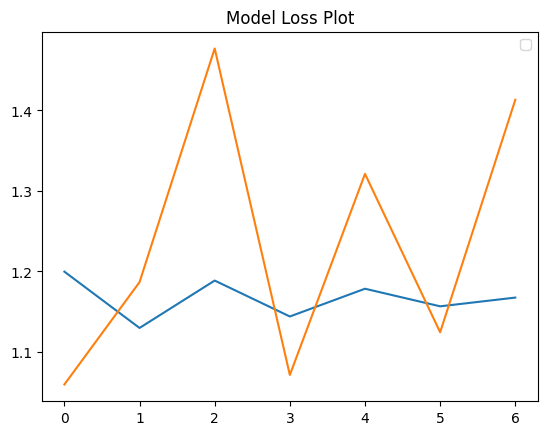

In [26]:

plt.plot(resnet_model_logs.history['loss'], label='train loss')
plt.plot(resnet_model_logs.history['val_loss'], label='val loss')
plt.title("Model Loss Plot")
plt.legend('Train', 'Valid')
plt.show()

<ipython-input-27-a97957b9dd45>:4: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Train', 'Valid')


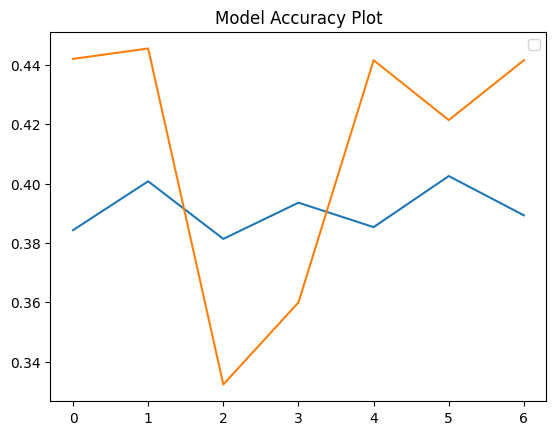

In [27]:

plt.plot(resnet_model_logs.history['categorical_accuracy'], label='train categorical_accuracy')
plt.plot(resnet_model_logs.history['val_categorical_accuracy'], label='val categorical_accuracy')
plt.title("Model Accuracy Plot")
plt.legend('Train', 'Valid')
plt.show()

## Testing